In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [2]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)


def error_level_analysis(image, quality=98):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None


def preprocess_image(image, image_size=(224, 224)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.1, ela_resized, 0.9, 0)

In [3]:
def prepare_dataset(dataset_path, image_size=(224, 224), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    Add,
    Multiply,
    Activation,
    Lambda,
    Concatenate,
    Conv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def cbam_module(inputs, reduction_ratio=8):
    """
    CBAM: Convolutional Block Attention Module.
    This function implements the CBAM block as described in the paper:
    https://arxiv.org/abs/1807.06521.
    
    The module infers attention maps along two separate dimensions, channel and spatial,
    then the attention maps are multiplied to the input feature map for adaptive feature refinement.

    Args:
        inputs (Tensor): Input tensor.
        reduction_ratio (int): The reduction ratio for the channel attention MLP.

    Returns:
        Tensor: The output tensor after applying CBAM.
    """
    # Get the number of channels from the input tensor shape
    channel = inputs.shape[-1]

    # ----- Channel Attention Module -----
    # This module focuses on 'what' is meaningful in the input image.
    
    # Shared Multi-Layer Perceptron (MLP) for both average and max-pooled features.
    shared_mlp_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_mlp_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    # Global Average Pooling branch
    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool_out = shared_mlp_two(shared_mlp_one(avg_pool))

    # Global Max Pooling branch
    max_pool = GlobalMaxPooling2D()(inputs)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool_out = shared_mlp_two(shared_mlp_one(max_pool))

    # Add the outputs of both branches and apply a sigmoid activation to get the channel attention map.
    channel_attention = Activation('sigmoid')(Add()([avg_pool_out, max_pool_out]))

    # Multiply the channel attention map with the input tensor to refine features channel-wise.
    channel_refined_feature = Multiply()([inputs, channel_attention])

    # ----- Spatial Attention Module -----
    # This module focuses on 'where' is the most informative part.
    
    # Apply average and max pooling along the channel axis to get 2D feature maps.
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(channel_refined_feature)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(channel_refined_feature)
    
    # Concatenate the two feature maps to create an efficient feature descriptor.
    concat_spatial = Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])

    # Apply a convolution layer to generate the spatial attention map.
    # A 7x7 kernel is used as it was shown to be effective in the original paper.
    spatial_attention = Conv2D(1, kernel_size=(7, 7), strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat_spatial)

    # Multiply the spatial attention map with the channel-refined feature map.
    refined_feature = Multiply()([channel_refined_feature, spatial_attention])

    return refined_feature

def build_model_with_fine_tuning(input_shape=(224, 224, 3), fine_tune_at=30):
    """
    Builds and compiles a MobileNetV2 model with a CBAM module,
    implementing a fine-tuning strategy for better performance.

    Args:
        input_shape (tuple): The shape of the input images, e.g., (224, 224, 3).
        fine_tune_at (int): The layer index from which to start unfreezing and
                            training the base model layers. MobileNetV2 has 154 layers.
                            A value of 100 means the last 54 layers will be trainable.

    Returns:
        A compiled Keras Model ready for training.
    """
    # --- 1. Load the Pre-Trained Base Model ---
    # We use MobileNetV2 pre-trained on ImageNet. `include_top=False` removes the
    # original final classification layer.
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    # --- 2. Set Up the Fine-Tuning Strategy ---
    # This is the most critical change for improving performance.
    # Instead of freezing the entire base model, we make it trainable and then
    # freeze only the first `fine_tune_at` layers. The earlier layers in a CNN
    # learn very general features (like edges, colors), which are useful for most tasks.
    # The later layers learn more complex, task-specific features, which we want to adapt.
    base_model.trainable = True
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    print(f"Total layers in base_model: {len(base_model.layers)}")
    print(f"Number of trainable layers: {len(base_model.trainable_variables)}")

    # --- 3. Build the Model Architecture ---
    # Start with the input tensor.
    inputs = Input(shape=input_shape)
    
    # Pass the inputs through the base model.
    # We set `training=False` to ensure that BatchNormalization layers
    # run in inference mode, using their learned moving average and variance.
    # This is important when fine-tuning, as it prevents the new data from
    # drastically shifting the learned statistics of the pre-trained layers.
    x = base_model(inputs, training=False)

    # Apply our CBAM module to the output of the base model to refine its features.
    x = cbam_module(x)

    # Pool the refined features before passing them to the classifier.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x) # A small dropout for regularization.

    # Add a new classifier head. A single dense layer is often sufficient for
    # transfer learning and reduces the risk of overfitting.
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x) # More aggressive dropout before the final layer.

    # Final output layer for binary classification.
    outputs = Dense(1, activation='sigmoid')(x)

    # --- 4. Create and Compile the Final Model ---
    model = Model(inputs, outputs)

    # Compile the model. A very low learning rate is crucial for fine-tuning.
    # It prevents the model from destroying the pre-trained weights.
    model.compile(
        optimizer=Adam(learning_rate=2e-4),  # Start with a low learning rate.
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
    )

    return model

# --- How to Use and Train ---
# 1. Build the model.
#    You can adjust `fine_tune_at` based on your dataset size and similarity to ImageNet.
#    A smaller dataset might benefit from freezing more layers (a larger `fine_tune_at` value).
# model = build_model_with_fine_tuning(input_shape=(224, 224, 3), fine_tune_at=100)

# 2. Display the model summary to verify the architecture and trainable parameters.
# model.summary()

# 3. Train the model on your dataset.
#    Assume you have `train_dataset` and `validation_dataset` as tf.data.Dataset objects.
# history = model.fit(train_dataset,
#                     epochs=20,  # Train for a sufficient number of epochs
#                     validation_data=validation_dataset)

# 4. (Optional) Further Fine-Tuning:
#    After an initial training phase, you can sometimes achieve even better results by
#    unfreezing more layers (or the entire model) and continuing to train with an
#    even smaller learning rate (e.g., 1e-6). This should be done carefully to
#    avoid overfitting.


In [5]:
def train_model(model, X, y, epochs=80):
    """Train the model with optimized parameters and class weighting."""
    X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)
    # early_stopping = EarlyStopping(
    #     monitor="val_loss", patience=10, restore_best_weights=True
    # )
    # lr_scheduler = ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.2, patience=10, min_lr=1e-7
    # )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
    )
    return model, history, X_test, y_test

In [6]:
# def evaluate_model(model, X_test, y_test):
#     """Evaluate the model on the test set and generate various plots."""
#     test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
#     y_pred_proba = model.predict(X_test)
#     y_pred = (y_pred_proba > 0.5).astype(int).flatten()

#     print("\nTest Metrics:")
#     print(classification_report(y_test, y_pred))

#     # Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(
#         cm,
#         annot=True,
#         fmt="d",
#         cmap="Blues",
#         xticklabels=["Non-Forged", "Forged"],
#         yticklabels=["Non-Forged", "Forged"],
#     )
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
#     plt.plot([0, 1], [0, 1], "k--")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend()
#     plt.show()

#     # Precision-Recall Curve
#     precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
#     plt.figure()
#     plt.plot(recall, precision, label="Precision-Recall Curve")
#     plt.xlabel("Recall")
#     plt.ylabel("Precision")
#     plt.legend()
#     plt.show()



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate various plots."""
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nTest Metrics:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    # Recall vs Threshold Curve
    # The precision_recall_curve returns thresholds that are 1 shorter than recall and precision arrays,
    # so align them properly for plotting.
    thresholds = _  # thresholds from precision_recall_curve
    recall_for_thresholds = recall[:-1]  # exclude last recall to align with thresholds

    plt.figure()
    plt.plot(thresholds, recall_for_thresholds, label="Recall vs Threshold", color="green")
    plt.xlabel("Threshold")
    plt.ylabel("Recall")
    plt.title("Recall vs Threshold Curve")
    plt.legend()
    plt.show()


In [7]:
# Step 1: Build model
image_size = (224, 224,3)
model = build_model_with_fine_tuning(image_size)
model.summary()

Total layers in base_model: 154
Number of trainable layers: 126


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1,      │          0 │ global_max_pooli… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 160) │    204,960 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1,      │    206,080 │ dense[0][0],      │
│                     │ 1280)             │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1,      │          0 │ dense_1[0][0],    │
│                     │ 1280)             │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1,      │          0 │ add[0][0]         │
│ (Activation)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ mobilenetv2_1.00… │
│                     │ 1280)             │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 2)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 1)   │         98 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 1280)             │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p

 Total params: 2,833,219 (10.81 MB)

 Trainable params: 2,779,571 (10.60 MB)

 Non-trainable params: 53,648 (209.56 KB)

In [8]:
image_size = (224, 224)
# Step 2: Define dataset path and image size
dataset_path = r"../CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [9]:
model, history, X_test, y_test = train_model(model, X, y, epochs=20)


(10091, 224, 224, 3) (10091,)
(1261, 224, 224, 3) (1261,)
(1262, 224, 224, 3) (1262,)
Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.8547 - auc: 0.9278 - loss: 0.5182 - val_accuracy: 0.5935 - val_auc: 0.5010 - val_loss: 10.7019
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.9399 - auc: 0.9870 - loss: 0.2782 - val_accuracy: 0.5951 - val_auc: 0.5029 - val_loss: 8.9824
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.9490 - auc: 0.9905 - loss: 0.2252 - val_accuracy: 0.6046 - val_auc: 0.5497 - val_loss: 6.1358
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9665 - auc: 0.9958 - loss: 0.1594 - val_accuracy: 0.6339 - val_auc: 0.6216 - val_loss: 5.2708
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9666 - auc: 0.9951 - loss: 0.1421 - val_accuracy: 0.6133 - val_auc: 0.5672 - val_loss: 6.0769
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9768 - auc: 0.9979 - loss: 0.1037 - val_a

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - accuracy: 0.9350 - auc: 0.9716 - loss: 0.3245
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 445ms/step

Test Metrics:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       749
           1       0.90      0.96      0.93       512

    accuracy                           0.94      1261
   macro avg       0.93      0.94      0.94      1261
weighted avg       0.94      0.94      0.94      1261



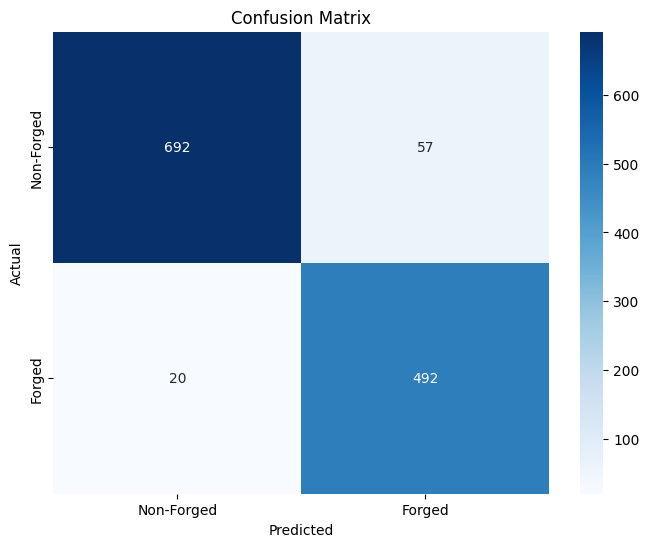

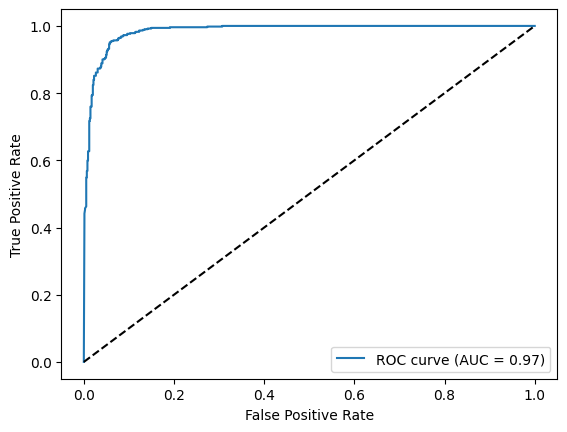

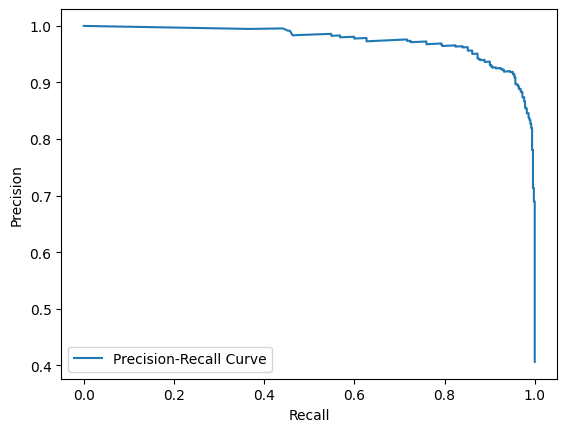

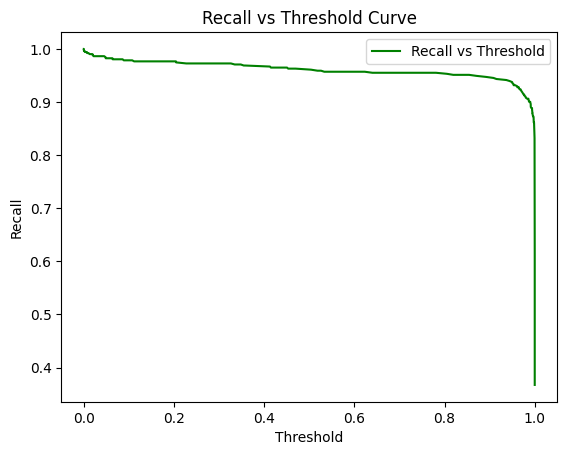

In [10]:
evaluate_model(model, X_test, y_test)

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss'])


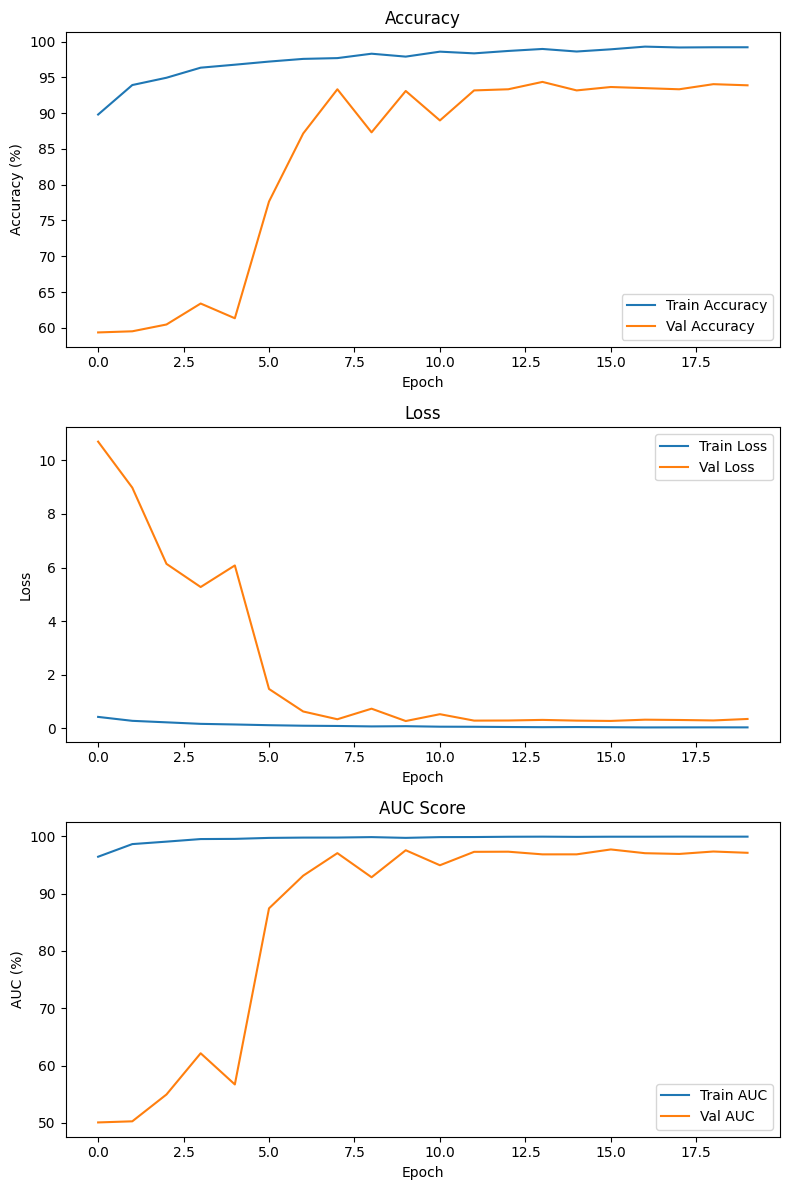

In [11]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history["accuracy"]) * 100, label="Train Accuracy")
    ax[0].plot(np.array(history.history["val_accuracy"]) * 100, label="Val Accuracy")
    ax[0].set_title("Accuracy")
    ax[0].set_ylabel("Accuracy (%)")
    ax[0].set_xlabel("Epoch")
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history["loss"]), label="Train Loss")
    ax[1].plot(np.array(history.history["val_loss"]), label="Val Loss")
    ax[1].set_title("Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    ax[2].plot(np.array(history.history["auc"]) * 100, label="Train AUC")
    ax[2].plot(np.array(history.history["val_auc"]) * 100, label="Val AUC")
    ax[2].set_title("AUC Score")
    ax[2].set_ylabel("AUC (%)")
    ax[2].set_xlabel("Epoch")
    # ax[2].set_ylim(80, 110)
    ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# Step 6: Plot training curves
plot_training_curves(history)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def plot_training_curves(history, save_plot=False, figsize=(15, 10)):
    """
    Enhanced training history plotting with better visualization and analysis.
    
    Args:
        history: Keras training history object
        save_plot: Whether to save the plot as an image
        figsize: Figure size tuple
    """
    
    print("📊 Available metrics:", list(history.history.keys()))
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Training History Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    # Get epochs
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Extract data
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    train_loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    
    # Plot 1: Accuracy with enhanced styling
    axes[0, 0].plot(epochs, train_acc * 100, 'o-', linewidth=3, markersize=6, 
                   color='#2E86AB', label='Training Accuracy', alpha=0.8)
    axes[0, 0].plot(epochs, val_acc * 100, 's-', linewidth=3, markersize=6, 
                   color='#F24236', label='Validation Accuracy', alpha=0.8)
    
    # Add best validation accuracy point
    best_val_epoch = np.argmax(val_acc) + 1
    best_val_acc = np.max(val_acc) * 100
    axes[0, 0].plot(best_val_epoch, best_val_acc, 'g*', markersize=15, 
                   label=f'Best Val Acc: {best_val_acc:.2f}%')
    
    axes[0, 0].set_title('Model Accuracy Over Time', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 100)
    
    # Add accuracy gap annotation
    final_train_acc = train_acc[-1] * 100
    final_val_acc = val_acc[-1] * 100
    acc_gap = final_train_acc - final_val_acc
    axes[0, 0].text(0.02, 0.98, f'Final Gap: {acc_gap:.1f}%', 
                   transform=axes[0, 0].transAxes, fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                   verticalalignment='top')
    
    # Plot 2: Loss with enhanced styling
    axes[0, 1].plot(epochs, train_loss, 'o-', linewidth=3, markersize=6, 
                   color='#2E86AB', label='Training Loss', alpha=0.8)
    axes[0, 1].plot(epochs, val_loss, 's-', linewidth=3, markersize=6, 
                   color='#F24236', label='Validation Loss', alpha=0.8)
    
    # Add best validation loss point
    best_val_loss_epoch = np.argmin(val_loss) + 1
    best_val_loss = np.min(val_loss)
    axes[0, 1].plot(best_val_loss_epoch, best_val_loss, 'g*', markersize=15, 
                   label=f'Best Val Loss: {best_val_loss:.3f}')
    
    axes[0, 1].set_title('Model Loss Over Time', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Training Analysis - Overfitting Detection
    axes[1, 0].fill_between(epochs, train_acc * 100, val_acc * 100, 
                           where=(train_acc >= val_acc), color='red', alpha=0.3, 
                           label='Potential Overfitting', interpolate=True)
    axes[1, 0].fill_between(epochs, train_acc * 100, val_acc * 100, 
                           where=(train_acc < val_acc), color='green', alpha=0.3, 
                           label='Good Generalization', interpolate=True)
    
    axes[1, 0].plot(epochs, train_acc * 100, 'b-', linewidth=2, alpha=0.7)
    axes[1, 0].plot(epochs, val_acc * 100, 'r-', linewidth=2, alpha=0.7)
    
    axes[1, 0].set_title('Overfitting Analysis', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Learning Rate and Convergence Analysis
    # Calculate learning rate (approximation based on loss change)
    loss_change = np.abs(np.diff(train_loss))
    learning_stability = 1 / (1 + loss_change * 10)  # Stability metric
    
    axes[1, 1].plot(epochs[1:], learning_stability, 'g-', linewidth=3, 
                   label='Learning Stability')
    axes[1, 1].set_title('Learning Stability Over Time', fontweight='bold', fontsize=12)
    axes[1, 1].set_ylabel('Stability Score', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add convergence annotation
    if len(epochs) > 10:
        recent_stability = np.mean(learning_stability[-5:])
        if recent_stability > 0.8:
            conv_status = "Converged"
            conv_color = "green"
        elif recent_stability > 0.6:
            conv_status = "Converging"
            conv_color = "orange"
        else:
            conv_status = "Unstable"
            conv_color = "red"
            
        axes[1, 1].text(0.02, 0.98, f'Status: {conv_status}', 
                       transform=axes[1, 1].transAxes, fontsize=10, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=conv_color, alpha=0.7),
                       verticalalignment='top')
    
    plt.tight_layout()
    
    # Print analysis summary
    print_training_analysis(train_acc, val_acc, train_loss, val_loss, epochs)
    
    if save_plot:
        plt.savefig('training_curves_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()

def print_training_analysis(train_acc, val_acc, train_loss, val_loss, epochs):
    """Print detailed training analysis."""
    
    print("\n" + "="*60)
    print("🔍 TRAINING ANALYSIS SUMMARY")
    print("="*60)
    
    # Final metrics
    final_train_acc = train_acc[-1] * 100
    final_val_acc = val_acc[-1] * 100
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    
    print(f"📈 Final Training Accuracy:   {final_train_acc:.2f}%")
    print(f"📊 Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"📉 Final Training Loss:       {final_train_loss:.4f}")
    print(f"📋 Final Validation Loss:     {final_val_loss:.4f}")
    
    # Performance gaps
    acc_gap = final_train_acc - final_val_acc
    loss_gap = final_val_loss - final_train_loss
    
    print(f"\n🔍 Performance Gaps:")
    print(f"   Accuracy Gap:  {acc_gap:.2f}%")
    print(f"   Loss Gap:      {loss_gap:.4f}")
    
    # Best performance
    best_val_acc = np.max(val_acc) * 100
    best_val_epoch = np.argmax(val_acc) + 1
    best_val_loss = np.min(val_loss)
    best_loss_epoch = np.argmin(val_loss) + 1
    
    print(f"\n🏆 Best Performance:")
    print(f"   Best Val Accuracy: {best_val_acc:.2f}% (Epoch {best_val_epoch})")
    print(f"   Best Val Loss:     {best_val_loss:.4f} (Epoch {best_loss_epoch})")
    
    # Training diagnosis
    print(f"\n🩺 Training Diagnosis:")
    
    if acc_gap > 15:
        print("   ⚠️  SEVERE OVERFITTING DETECTED")
        print("   💡 Suggestions: Reduce model complexity, add regularization, early stopping")
    elif acc_gap > 8:
        print("   ⚠️  MODERATE OVERFITTING")
        print("   💡 Suggestions: Add dropout, reduce learning rate, data augmentation")
    elif acc_gap > 3:
        print("   ✅ SLIGHT OVERFITTING (Normal)")
        print("   💡 Model is learning well with minor overfitting")
    else:
        print("   ✅ GOOD GENERALIZATION")
        print("   💡 Model is generalizing well to validation data")
    
    # Convergence analysis
    recent_epochs = min(5, len(epochs) // 4)
    recent_val_acc_std = np.std(val_acc[-recent_epochs:])
    
    if recent_val_acc_std < 0.01:
        print(f"   📈 CONVERGED: Validation accuracy is stable")
    elif recent_val_acc_std < 0.02:
        print(f"   📈 CONVERGING: Small fluctuations in validation accuracy")
    else:
        print(f"   📈 STILL LEARNING: Validation accuracy still changing")
    
    # Training recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if final_val_acc < 70:
        print("   🔧 Low accuracy: Try different architecture, more data, or feature engineering")
    
    if loss_gap > 0.5:
        print("   🔧 High loss gap: Implement early stopping or reduce model complexity")
    
    if best_val_epoch < len(epochs) * 0.7:
        print("   🔧 Early peak: Consider early stopping or learning rate scheduling")
    
    print("="*60)

def plot_simple_training_curves(history):
    """Simplified version of the original function with enhancements."""
    
    print("Available metrics:", list(history.history.keys()))
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Enhanced Accuracy Plot
    ax[0].plot(epochs, np.array(history.history['accuracy']) * 100, 
               'o-', linewidth=2, markersize=4, label='Training Accuracy', color='blue')
    ax[0].plot(epochs, np.array(history.history['val_accuracy']) * 100, 
               's-', linewidth=2, markersize=4, label='Validation Accuracy', color='red')
    
    ax[0].set_title('Model Accuracy', fontweight='bold', fontsize=14)
    ax[0].set_ylabel('Accuracy (%)', fontweight='bold')
    ax[0].set_xlabel('Epoch', fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    ax[0].set_ylim(0, 100)
    
    # Enhanced Loss Plot
    ax[1].plot(epochs, np.array(history.history['loss']), 
               'o-', linewidth=2, markersize=4, label='Training Loss', color='blue')
    ax[1].plot(epochs, np.array(history.history['val_loss']), 
               's-', linewidth=2, markersize=4, label='Validation Loss', color='red')
    
    ax[1].set_title('Model Loss', fontweight='bold', fontsize=14)
    ax[1].set_ylabel('Loss', fontweight='bold')
    ax[1].set_xlabel('Epoch', fontweight='bold')
    ax[1].set_ylim(0,2)
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_curves(history)  # Enhanced version
# plot_simple_training_curves(history)  # Simple enhanced version

Available metrics: ['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss']


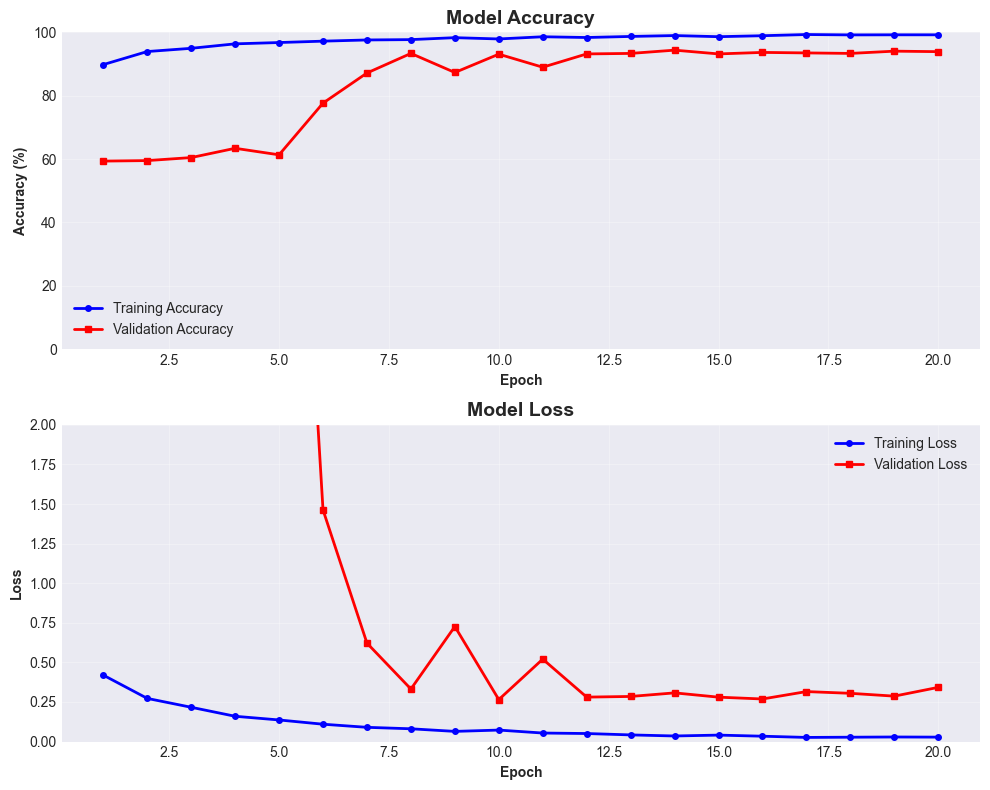

In [13]:
plot_simple_training_curves(history)

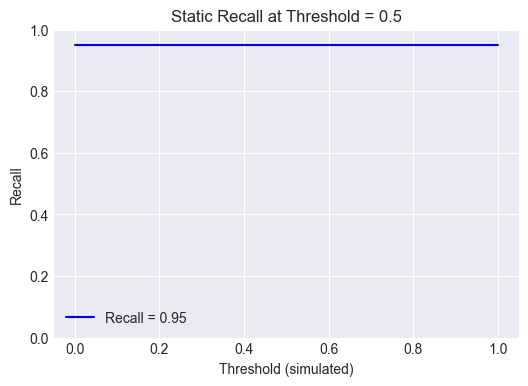

In [14]:
import matplotlib.pyplot as plt

recall = 487 / (487 + 25)

# Simulated x-axis range for thresholds (just for visualization)
thresholds = [0.0, 1.0]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, [recall, recall], label=f'Recall = {recall:.2f}', color='blue')
plt.ylim(0, 1)
plt.xlabel("Threshold (simulated)")
plt.ylabel("Recall")
plt.title("Static Recall at Threshold = 0.5")
plt.legend()
plt.grid(True)
plt.show()
